<a href="https://colab.research.google.com/github/wileyw/DeepLearningDemos/blob/master/SiameseNetwork/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Network

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
!unzip drive/MyDrive/fruits-360.zip -d drive/MyDrive
# https://towardsdatascience.com/siamese-networks-line-by-line-explanation-for-beginners-55b8be1d2fc6

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive


MyDrive  Shareddrives


## Data Preprocessing

In [48]:
base_dir = r'/content/drive/MyDrive/fruits-360/Training/'
train_test_split = 0.7
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just no_of_files_in_each_class images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    if len(files_list) < no_of_files_in_each_class:
      continue
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)

131 categories found in the dataset
X, Y shape (1120, 100, 100, 3) (1120,) (112, 10)


[[[255 253 250]
  [255 254 252]
  [250 255 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 254 252]
  [255 255 253]
  [251 255 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 255 252]
  [254 255 255]
  [254 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
test


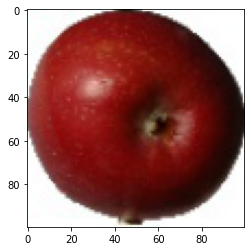

In [46]:
print(np.asarray(Image.open("/content/drive/MyDrive/fruits-360/Training/Apple Braeburn/r_289_100.jpg").convert('RGB').resize((100, 100))))
print("test")
plt.imshow(np.asarray(Image.open("/content/drive/MyDrive/fruits-360/Training/Apple Braeburn/r_289_100.jpg").convert('RGB').resize((100, 100)))/255.)
# im = Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB')

In [50]:
x = x.transpose(0, 3, 1, 2)
print('X, Y shape',x.shape, y.shape, cat_list.shape)

X, Y shape (1120, 3, 100, 100) (1120,) (112, 10)


## Train Test Split

In [52]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

91 classes for training and 40  classes for testing
X&Y shape of training data : (910, 3, 100, 100) and (910,) (91, 10)
X&Y shape of testing data : (210, 3, 100, 100) and (210,) (21, 10)


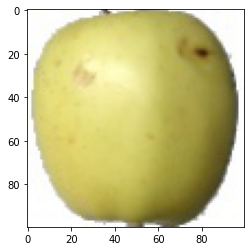

In [58]:
# plt.imshow(x[30].transpose(1,2,0))

## Generating Batch

In [59]:
def get_batch(batch_size=64):
    
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]
        
    batch_y = np.zeros(batch_size)
    # batch_y = np.one(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 3, 100, 100)))
    batch_x.append(np.zeros((batch_size, 3, 100, 100)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

## Siamese Network

In [101]:
#Building a sequential model
class CnnNetwork(nn.Module):

    def __init__(self):
        super(CnnNetwork, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 64, 10)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256 * 4, 4096) # TODO: Change it for sure.

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.sigmoid(self.fc1(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
# b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
#     keras.layers.MaxPooling2D(2, 2),
#     keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
# ])

########## TODO: 
# encoded_l = CnnNetwork(left_input)
# encoded_r = CnnNetwork(right_input)

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.cnn = CnnNetwork()
        self.fc1 = nn.Linear(4096, 1) # TODO: To check.

    def forward(self, left, right):
        # Max pooling over a (2, 2) window
        x = self.cnn(left)
        y = self.cnn(right)
        diff = x - y
        # z = F.sigmoid(self.fc1(diff))
        z = F.tanh(self.fc1(diff))
        # z = (x-y).pow(2).sum()
        return z
# TODO: optimizer
# learning_rate = 0.0006
learning_rate = 0.003
siamese_net = SiameseNetwork().cuda()
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=learning_rate)

# loss = nn.MSELoss()
loss = nn.BCELoss()

# subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
# prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
# siamese_net = Model(input=[left_input, right_input], output=prediction)

# optimizer= Adam(learning_rate=0.0006)
# siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

# plot_model(siamese_net, show_shapes=True, show_layer_names=True)

## N-way one-shot Learning

In [86]:
def nway_one_shot(n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(cat_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 3, 100, 100)))
        temp.append(np.zeros((n_way, 3, 100, 100)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        # TODO: change here
        result = siamese_net(torch.Tensor(temp[0]).cuda(), torch.Tensor(temp[1]).cuda())
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

In [71]:
# batch_x, batch_y = get_batch(batch_size)

In [ ]:
# print(batch_y)
# print(len(batch_x))
# print(batch_y.shape)
# print(batch_x[0][0].shape)
# plt.imshow(batch_x[0][10].transpose(1,2, 0))
# plt.show()
# plt.imshow(batch_x[1][10].transpose(1,2, 0))
# plt.show()


## Training the Model

In [102]:
batch_x_0, batch_y_0 = get_batch(batch_size)
batch_x_1, batch_y = get_batch(batch_size)

In [103]:
siamese_outputs = siamese_net(torch.Tensor(batch_x_0[0]).cuda(), torch.Tensor(batch_x_1[1]).cuda())
print(f"siamese_outputs is {siamese_outputs}")


siamese_outputs is tensor([[0.5029],
        [0.5032],
        [0.5027],
        [0.5028],
        [0.5028],
        [0.5028],
        [0.5032],
        [0.5028],
        [0.5026],
        [0.5033],
        [0.5023],
        [0.5029],
        [0.5029],
        [0.5025],
        [0.5026],
        [0.5027],
        [0.5029],
        [0.5030],
        [0.5026],
        [0.5025],
        [0.5026],
        [0.5028],
        [0.5032],
        [0.5029],
        [0.5028],
        [0.5028],
        [0.5026],
        [0.5028],
        [0.5028],
        [0.5029],
        [0.5030],
        [0.5025],
        [0.5028],
        [0.5023],
        [0.5028],
        [0.5028],
        [0.5027],
        [0.5024],
        [0.5031],
        [0.5026],
        [0.5025],
        [0.5025],
        [0.5027],
        [0.5025],
        [0.5026],
        [0.5027],
        [0.5027],
        [0.5030],
        [0.5024],
        [0.5028],
        [0.5030],
        [0.5026],
        [0.5025],
        [0.5030],
        [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [94]:
epochs = 30000
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(epochs):
    batch_x, batch_y = get_batch(batch_size)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    siamese_outputs = siamese_net(torch.Tensor(batch_x[0]).cuda(), torch.Tensor(batch_x[1]).cuda())
    # print(siamese_net)
    print(f"siamese_outputs is {siamese_outputs}")
    for param in siamese_net.parameters():
        print(param.data)
    # print(f"batch_y is {batch_y}")
    outputs = loss(siamese_outputs, torch.Tensor(batch_y).reshape(64, 1).cuda())
    outputs.backward()
    optimizer.step()

    print('Epoch:', epoch, ', Loss:',outputs)
    loss_list.append((epoch,outputs.item()))
    # print statistics
    if epoch % 250 == 0:    # print every 2000 mini-batches
        print("=============================================")
        accuracy = nway_one_shot(n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
           -1.6346e-02, -7.6186e-03]],

         [[-1.9599e-02, -3.1246e-03,  2.5020e-03,  ..., -2.6881e-02,
           -1.2635e-02, -1.6484e-02],
          [ 2.7748e-02,  3.0299e-02,  2.5476e-03,  ..., -2.3783e-03,
           -1.0327e-02, -2.6994e-02],
          [ 2.2405e-03,  2.0918e-02,  2.7844e-02,  ..., -2.5295e-03,
           -1.6652e-02, -3.4034e-02],
          ...,
          [-2.5011e-02, -1.5415e-02, -8.8822e-03,  ..., -4.5498e-03,
           -2.6936e-02, -9.5228e-04],
          [-4.4581e-03, -3.5693e-02, -7.6536e-03,  ..., -1.3983e-02,
           -1.5591e-02, -2.5827e-02],
          [-2.0198e-02, -6.0481e-03, -1.1185e-02,  ..., -8.9973e-04,
           -9.8989e-03, -1.2915e-02]],

         ...,

         [[-3.0761e-02, -1.3675e-02,  1.6296e-02,  ...,  2.6767e-02,
           -1.3638e-02, -9.7924e-03],
          [-1.7437e-02, -1.9218e-02, -1.9160e-02,  ...,  1.0849e-02,
           -2.8166e-02, -3.4938e-02],
          [ 3.0269e-0

KeyboardInterrupt: ignored